In [1]:
cd C:\Users\USER\Quant

C:\Users\USER\Quant


In [2]:
import Quant_Strategy as Quant_Strategy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
path = '재무데이터.xlsx'
path_price = '수정주가.csv'
path_mkt = '시총데이터.csv'
path_endmonth = '결산월.csv'
path_kospiyn = '거래소데이터.csv'
path_delist_and_stop = '상장폐지데이터.csv'
### 추가된 데이터 ###
path_kospi_and_interest = 'kospi_interest_data.xlsx'

In [4]:
cleaned_data = Quant_Strategy.preprocessing_path(path)
cleaned_price = Quant_Strategy.preprocessing_price(path_price)
cleaned_kospiyn = Quant_Strategy.preprocessing_kospiyn(path_kospiyn)
cleaned_mkt = Quant_Strategy.preprocessing_mktdata(path_mkt)
delist_data, stop_data = Quant_Strategy.preprocessing_stop_and_delist(path_delist_and_stop)
cleaned_endmonth = Quant_Strategy.preprocessing_period(path_endmonth)

In [5]:
start_day = '1983-06-30'
end_day = '2021-01-31'
PF  = Quant_Strategy.backtest(Quant_Strategy.F_score , start_day, end_day, cleaned_data, cleaned_price,
                              cleaned_mkt, delist_data, stop_data,cleaned_kospiyn,
                              rebalance_freq = 3, number_of_stock = 50, initial_money = 10000)

 ### 문제 1. kospi_interest_data.xlsx 에는 코스피지수 데이터와 콜금리가 들어있다.  
 
 #### 금리는 x100로 표시된 상태이므로 100으로 나눠주어야한다.
 다음과 같은 함수를 만드시오.
 
 kospi_riskfree = preprocessing_kospi_and_rf(path_kospi_and_interest)

 결과로 코스피지수의 시리즈와 콜금리의 시리즈를 리턴한다.
 
 (콜금리의 경우 1987년까지 NaN값이므로 back filling한다.)
 
 결과창 : 
 
 | |kospi|risk_free_rate|
|------|---|---|
|1980-01-31|	105.89|	0.095|
|1980-02-29|	103.74|	0.095|
|1980-03-31|	105.00|	0.095|
|1980-04-30|	116.09|	0.095|
|1980-05-31|	116.43|	0.095|

In [6]:
def preprocessing_kospi_and_rf(path_kospi_and_interest) :
    ########################
    #### 풀이과정      #####
    ########################
    return kospi_riskfree

In [7]:
def preprocessing_kospi_and_rf(path_kospi_and_interest) :
    kospi_and_interest = pd.read_excel('kospi_interest_data.xlsx', index_col = 0)
    kospi = kospi_and_interest[kospi_and_interest.columns[0]]
    riskfree = kospi_and_interest[kospi_and_interest.columns[1]].fillna(method = 'bfill')/100
    kospi_riskfree = pd.concat([kospi,riskfree],axis = 1)
    return kospi_riskfree

 #### 결과창

In [8]:
kospi_riskfree = preprocessing_kospi_and_rf(path_kospi_and_interest)
kospi_riskfree.head()

,kospi,risk_free_rate
Symbol Name,,
1980-01-31,105.89,0.095
1980-02-29,103.74,0.095
1980-03-31,105.00,0.095
1980-04-30,116.09,0.095
1980-05-31,116.43,0.095


## 문제2. 다음과 같은 데이터프레임을 리턴해주는 함수를 만드시오.

#### 변수는 백테스트 결과로 얻은 1. 포트폴리오 가치와 2.코스피지수 시리즈

#### def port_performance(Portvalue_Dataframe, kospi_riskfree) :



##### 결과창 

| |initial|final|CAGR|Stdev|MDD|Sharp|Best_Year|Worst_Year|Market_Corr|
|------|---|---|---|---|---|---|---|---|---|
| 1983-06 ~ 2020-12|10000 |7130201|0.191 |0.285|-0.624 |0.672|1.141|-0.37|0.765|

Draw Down은 직전 12개월까지 포트폴리오 가치의 max값에서 현재 값을 뺀 것을 12개월 포트폴리오 가치의 max값으로 나눠준 것이다.

포트폴리오 가치가 monthly 시리즈로 나타내 있다면 다음과 같이 표현할 수 있다.

$$
\begin{array}{c}
Draw \ Down = \frac{PortValue.rolling(12).max() - PortValue}{PortValue.rolling(12).max()}
\end{array}
$$


MDD 는 Maximum Draw Down으로 Draw Down에서 가장 낮은 수익률을 의미한다.

In [9]:
def port_performance(PF, kospi_riskfree) :
    ########################
    #### 풀이과정      #####
    ########################
    return data

In [10]:
def port_performance(PF, kospi_riskfree) :
    kospi = kospi_riskfree[kospi_riskfree.columns[0]]
    name = str(PF.index[0])[:7] + ' ~ '+str(PF.index[-1])[:7]
    kospi_return = kospi.pct_change()
    initial ,final = PF[PF.columns[0]].iloc[0],PF[PF.columns[0]].iloc[-1]
    T = ((PF.index[-1]-PF.index[0]).days/365)
    CAGR = (final/initial)**(1/T)-1
    Stdev = PF[PF.columns[0]].pct_change().iloc[1:].std() * np.sqrt(12)
    Sharp = CAGR/Stdev
    Draw_Down = -((PF[PF.columns[0]].rolling(12).max()- PF[PF.columns[0]])/PF[PF.columns[0]].rolling(12).max())
    MDD = Draw_Down.min()
    ret_Y = PF[PF.columns[0]].resample('Y').last().pct_change()
    Best_Y , Worst_Y = ret_Y.max() , ret_Y.min()
    Mkt_Corr = PF[PF.columns[0]].pct_change().corr(kospi_return)
    data = pd.DataFrame([initial,final,CAGR,Stdev,MDD,Sharp,
                         Best_Y,Worst_Y,Mkt_Corr],columns = [name]).T.round(3)
    data.columns = ['initial','final','CAGR','Stdev','MDD','Sharp','Best_Year','Worst_Year','Market_Corr']
    return data

In [11]:
port_performance(PF, kospi_riskfree)

,initial,final,CAGR,Stdev,MDD,Sharp,Best_Year,Worst_Year,Market_Corr
1983-06 ~ 2020-12,10000.0,7130201.0,0.191,0.285,-0.624,0.672,1.141,-0.37,0.765


 ### 문제 3. 특정 시점의 포트폴리오 베타는 다음과 같이 계산한다.
 
 $$
 \begin{array}{c}
 \beta_{(t)} = (X'\bullet X)^{-1} (X'Y) \\
 X = 코스피 월수익률 \ (t-60month부터\ t시점까지\ 60개의\ 수익률) \ \ shape = (60행\ , 1열) \\
 Y = 포트폴리오 월수익률 \ (t-60month부터\ t시점까지\ 60개의\ 수익률) \ \ shape = (60행\ , 1열)
\\ \\ 포트폴리오\ 시작\ 날짜가\ 1983년\ 6월\ 30일이라면\ 베타는\ 1984년\ 7월\ 31일부터\ 계산하시오.\ (과거\ 12개월 수익률을\ 기반으로\ 계산)
 \end{array}
 $$

베타를 6개월별로 계산하면 다음과 같다.

 | |beta|
|------|---|
|1983-07-31|NaN|
|1984-01-31|NaN|
| 1984-07-31|0.703	 |
| 1985-01-31|0.832 |
| 1985-07-31|0.593 |
| 1986-01-31|0.540 |
| 1986-07-31|0.707 |

### 베타를 monthly resample하여 linear interpolate하시오. 맨앞부분의 NaN의 경우 backfill 하시오. 

 ### 특정 시점의 포트폴리오 알파는 다음과 같이 계산된다.
 $$
 \begin{array}{c}
 \alpha_{(t)} = R_{portfolio}(t) - ( R_f(t) + \beta_{(t)} (R_m(t) - R_f(t))  )
 \end{array}
 $$
 
 포트폴리오 베타와 알파를 매월마다 계산하면 다음과 같다.
 
 | |Port_Return|rf|beta|kospi|alpha|
|------|---|---|---|---|---|
| 1984-05-31|0.000871	|0.008068|	0.702539	|-0.037758	|0.024997|
| 1984-06-30|0.110096	|0.007808	|0.702539|	-0.001533|	0.108851|
| 1984-07-31|-0.048577	|0.008068|	0.702539	|0.032699	|-0.073949|
| 1984-08-31|0.009333	|0.008068	|0.733676	|0.011669	|-0.001377|
| 1984-09-30|-0.028488	|0.007808	|0.764813	|-0.014474	|-0.019255|

위와 같이 매월의 포트폴리오 수익률, 무위험수익률(rf), 베타, kospi, alpha 를 보여주는 데이터프레임을 리턴하는 함수를 만드시오.

In [12]:
def calculate_monthly_beta_alpha(PF_DataFrame, kospi_riskfree) :
    ########################
    #### 풀이과정      #####
    ########################
    return data

In [13]:
def calculate_monthly_beta_alpha(PF_DataFrame, kospi_riskfree) :
    PF, kospi = PF_DataFrame , kospi_riskfree[kospi_riskfree.columns[0]]
    riskfree = kospi_riskfree[kospi_riskfree.columns[1]]
    PF_ret = PF[PF.columns[0]].pct_change().iloc[1:]
    kospi_ret = kospi.pct_change().iloc[1:][PF_ret.index[0]:PF_ret.index[-1]]
    DF = pd.concat([PF_ret,kospi_ret], axis = 1)
    end_date_ran = pd.date_range(DF.index[0] + pd.DateOffset(months = 12, day = 31) , DF.index[-1], freq = '6M')
    end_date_ran = end_date_ran.append(pd.Index([DF.index[-1]])).unique()
    beta_DF = pd.DataFrame([],index = [DF.index[0]], columns = ['beta'])
    for i in range(len(end_date_ran)) :
        end = end_date_ran[i]
        start = end - pd.DateOffset(months = 60, days = 31)
        y = np.array(DF[start:end][DF.columns[0]]).reshape(-1,1)
        x = np.array(DF[start:end][DF.columns[1]]).reshape(-1,1)
        beta = np.linalg.inv(x.T.dot(x)).dot(x.T.dot(y))[0][0]
        beta_DF = pd.concat([beta_DF,pd.DataFrame([beta],index = [end], columns = ['beta'])],axis = 0)
    beta_dataframe = beta_DF.resample('M').last().interpolate(method = 'linear').fillna(method = 'bfill')
    
    
    rf = riskfree[PF_ret.index[0]:PF_ret.index[-1]]
    deltaT = pd.Series(rf.index, index = rf.index).diff().fillna(method = 'bfill').apply(lambda x : x.days)/365
    monthly_rf = (rf * deltaT).rename('rf')
    data = pd.concat([PF_ret,monthly_rf,beta_dataframe, kospi_ret],axis = 1)    
    return data

 #### 결과창

In [14]:
monthly_data = calculate_monthly_beta_alpha(PF, kospi_riskfree)
monthly_data.head()

,Port_Value,rf,beta,kospi
1983-07-31,0.056500,0.008068,0.702539,0.021235
1983-08-31,-0.008708,0.008068,0.702539,-0.049744
1983-09-30,-0.018715,0.007808,0.702539,-0.009342
1983-10-31,0.075314,0.008068,0.702539,0.031518
1983-11-30,-0.008054,0.007808,0.702539,-0.031214


 ### 문제 4. 문제 3의 함수로 얻은 monthly data의 베타를 가져오고 monthly_beta라고 가정하자.
 
 ### rf_year는 무위험 연수익률이다.
 
 monthly_beta = calculate_monthly_beta_alpha(PF, kospi_riskfree)['beta']
 
 rf_year = kospi_riskfree['risk_free_rate']
 
 여기서 monthly 베타를 연별로 resample하자 ( last가 아닌 mean으로 resample하자.)
 
 이를 기반으로 포트폴리오의 연 알파값을 구하는 함수를 만드시오.
 
 결과창 : 
 
  | |Port_Return|rf|beta|kospi|alpha|
|------|---|---|---|---|---|
|1984-12-31|	0.379084	|0.095	|0.741460|	0.175316|	0.224533|
|1985-12-31|	0.016196	|0.095	|0.799138|	0.146778|	-0.120182|
|1986-12-31|	0.436313	|0.095	|0.590249|	0.668666|	0.002707|
|1987-12-31|	0.622384	|0.098	|0.723999|	0.926232|	-0.075255|
|1988-12-31|	0.221757	|0.102	|0.678455|	0.727638|	-0.304710|

In [15]:
def calculate_annual_alpha(PF,monthly_data) :
    ########################
    #### 풀이과정      #####
    ########################
    return 

In [16]:
def calculate_annual_alpha(PF,monthly_data) :
    data = monthly_data
    beta_Y  = data['beta'].resample('Y').mean()
    PF_Y = PF[PF.columns[0]].resample('Y').last().pct_change().dropna()
    kospi_ret_Y = kospi_riskfree['kospi'].resample('Y').last().pct_change()[PF_Y.index[0]:PF_Y.index[-1]]
    rf = kospi_riskfree[kospi_riskfree.columns[1]].resample('Y').last()
    data_Y = pd.concat([PF_Y,rf,beta_Y,kospi_ret_Y],axis=1).dropna()
    data_Y['alpha'] = data_Y[data_Y.columns[0]] - ( data_Y[data_Y.columns[1]] + data_Y[data_Y.columns[2]]*(data_Y[data_Y.columns[3]] -  data_Y[data_Y.columns[1]]) )
    return data_Y.rename(columns = {data_Y.columns[0]:'Ann_Return'})

In [17]:
annual_data = calculate_annual_alpha(PF,monthly_data)
annual_data.head()

,Ann_Return,risk_free_rate,beta,kospi,alpha
Symbol Name,,,,,
1984-12-31,0.379084,0.095,0.741460,0.175316,0.224533
1985-12-31,0.016196,0.095,0.799138,0.146778,-0.120182
1986-12-31,0.436313,0.095,0.590249,0.668666,0.002707
1987-12-31,0.622384,0.098,0.723999,0.926232,-0.075255
1988-12-31,0.221757,0.102,0.678455,0.727638,-0.304710


문제 5. 위의 두 가지의 함수를 기반으로 다음 요소들을 visualize하시오. 

1. 포트폴리오의 monthly 가치
2. Draw Down
3. Annualized 포트폴리오 수익률, 코스피 수익률, Annual alpha
4. 60개월 Moving Average Return, 코스피의 60개월 Moving Average Return


monthly_data = calculate_monthly_beta_alpha(PF, kospi_riskfree)

annual_data = calculate_annual_alpha(PF,monthly_data)

In [21]:
def plotting_backtest(PF , kospi_riskfree, ma_month = 60 , strategy_name = 'F_score') :
    ########################
    #### 풀이과정      #####
    ########################
    return

In [22]:
def plotting_backtest(PF , kospi_riskfree, ma_month = 60 , strategy_name = 'F_score') :
    monthly_data = calculate_monthly_beta_alpha(PF, kospi_riskfree)
    annual_data = calculate_annual_alpha(PF,monthly_data)
    kospi_ret_Y = annual_data[annual_data.columns[3]]
    PF_return_Y = annual_data[annual_data.columns[0]]
    alpha_Y = annual_data[annual_data.columns[4]]
    ind= np.arange(len(PF_return_Y))
    real_index = list(pd.Series(PF_return_Y.index).apply(lambda x : x.year))
    Draw_Down = -((PF[PF.columns[0]].rolling(12).max()- PF[PF.columns[0]])/PF[PF.columns[0]].rolling(12).max())
    MA_return = monthly_data[monthly_data.columns[0]].rolling(ma_month).mean()
    MA_return_kospi = monthly_data['kospi'].rolling(ma_month).mean()
    plt.figure(figsize = (16,16))
    plt.subplot(4,1,1)
    plt.ylabel('My Portfolio Value',fontsize=15)        
    plt.plot(PF[PF.columns[0]], label = 'my_portfolio_value')
    plt.legend(loc = 'best')

    plt.figure(figsize=(16,16))
    plt.subplot(4,1,2)
    plt.ylabel('Draw Down', fontsize =15)
    plt.plot(Draw_Down, color = 'black')


    plt.figure(figsize=(16,16))
    plt.subplot(4,1,3)
    plt.ylabel('annual return',fontsize=16)        
    plt.xticks(ind, real_index, rotation='vertical')
    plt.bar(ind , PF_return_Y, label = 'Ann_Ret' , width = 0.3 , color = 'b')
    plt.bar(ind+0.15 , kospi_ret_Y, label = 'KOSPI', width= 0.3, color = 'orange')
    plt.bar(ind+0.35, alpha_Y, label = 'Alpha', width = 0.3, color = 'red')
    plt.title(str(strategy_name)+' annual_performance', fontsize = 15 )
    plt.legend(loc = 'best')

    plt.figure(figsize = (16,16))
    plt.subplot(4,1,4)
    plt.title(str(ma_month) + ' Month Moving Average Return',fontsize=15)        
    plt.plot(MA_return, label = 'portfolio_return')
    plt.plot(MA_return_kospi, label = 'kospi_return')
    plt.legend(loc = 'best')
    plt.ylabel('return', fontsize = 15)
    plt.show()

 ### 결과창

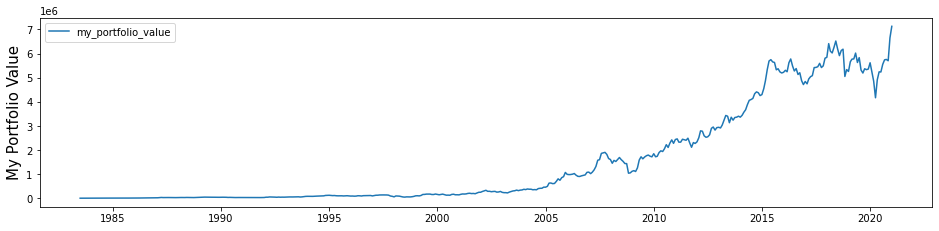

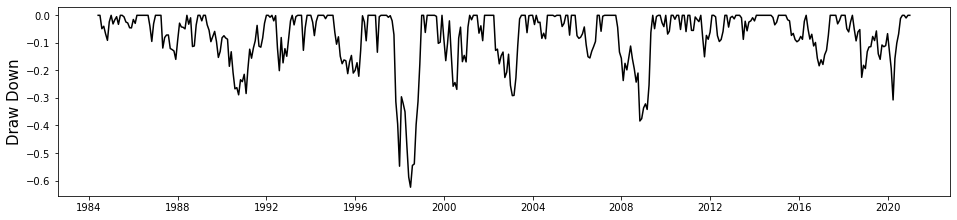

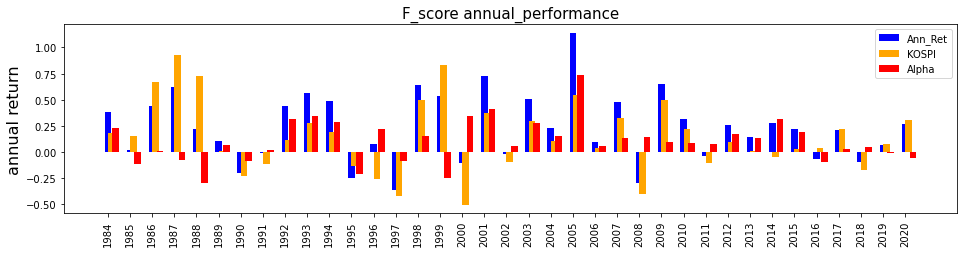

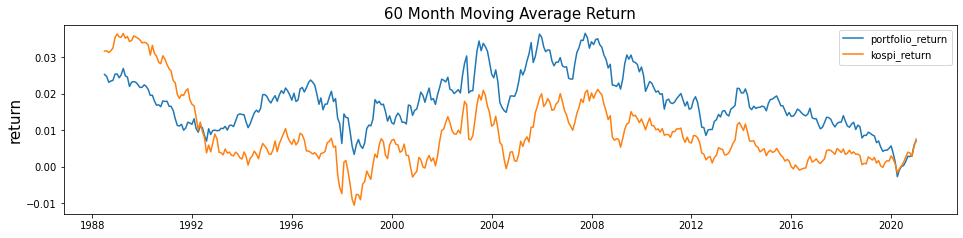

In [19]:
plotting_backtest(PF , kospi_riskfree, ma_month = 60 , strategy_name = 'F_score')